In [1]:
import warnings 
warnings.filterwarnings('ignore')
import espaloma as esp
import mbuild as mb
from openff.toolkit.topology import Molecule
from writers import foyer_xml_writer
from writers.foyer_xml_writer import mbuild_to_foyer_xml
from bondwalk import bond_walk
from bondwalk.bond_walk import MadAtom, MadBond, BondWalker
#import ipywidgets as widgets
import os
import torch
from openff.toolkit.topology import Molecule
import parmed as pmd
import networkx  as nx
if not os.path.exists("espaloma_model.pt"):
    os.system("wget http://data.wangyq.net/espaloma_model.pt")
    

#from r_classes import c11_bo,HD,ODD,C1BO,C3BO,C4BO,C5BO, C16
from mon_classes import PCPDTPT_nC16,PIDTBT_nC16, PCPDTPT_ODD,PIDTCPDT_C11BO, P3HT, PCPDTPT_HD, PDPPPyT_ODD, PCPDTFBT_C1_BO, PCPDTFBT_C3_BO, PCPDTFBT_C4_BO, PCPDTFBT_C5_BO, PIDTFBT_C11_BO,PCPDT_PT_eneHD, PCPDTFBT_C11_BO, BDT_TPD, perylene
from mbuild.lib.recipes.polymer import Polymer

def build_chain(monomer, length, min_energy):
    chain = Polymer()
    chain.add_monomer(compound=monomer,
                 indices=monomer.bond_indices,
                 separation=monomer.separation,
                 replace=monomer.replace,
                 orientation=monomer.orientations)
    chain.build(n=length)
    if min_energy == True:
        chain.energy_minimize()
    return chain


/Users/madilyn/miniconda3/envs/ff_new/lib/python3.10/site-packages/mbuild/recipes/__init__.py:13: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  entry_points = metadata.entry_points()["mbuild.plugins"]


In [6]:
from mon_classes import PIDTCPDT_C11BO

In [27]:
from frag_classes import IDT, CPDT, DPP, BT, PT, FBT, thiophene, pyridine 

In [32]:
cpdt = mb.load("C1(=C)C3=C(SC=C3)C2=C1C=CS2",smiles=True)
cpdt.visualize()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [33]:
cpdt.to_smiles()

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is Compound)



'C1(=c2c(=C3[C]1C=CS3)scc2)[CH2]'

In [7]:
monomer = build_chain(PIDTCPDT_C11BO(),1,min_energy=True)
dimer = build_chain(PIDTCPDT_C11BO(),2,min_energy=True)
mon_dim = mb.Compound()
mon_dim.add([monomer,dimer])
monomer.translate([3,3,3])
dimer.translate([-3,-3,-3])
#smiles_string = mon_dim.to_smiles()

In [34]:
comp = Molecule.from_smiles('C1(=c2c(=C3[C]1C=CS3)scc2)[CH2]')
comp.visualize()

RadicalsNotSupportedError: The OpenFF Toolkit does not currently support parsing molecules with S- and P-block radicals. Found 1 radical electrons on molecule [H][C]([H])C1=C2C([H])=C([H])SC2=C2SC([H])=C([H])[C]21.

In [18]:
bonds = [b for b in comp.bonds]
for i in range(len(bonds)):
    bonds[i].bond_order = 1

In [19]:
b= BondWalker(comp)

In [20]:
molecule = b.fill_in_bonds()

Sorry- I couldn't solve this


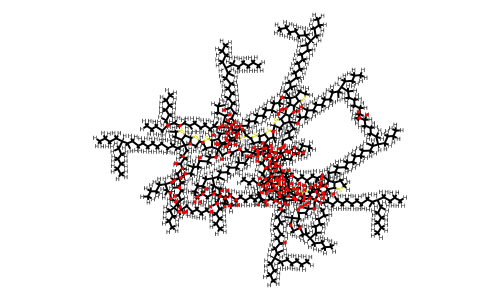

In [21]:
comp.visualize()

In [ ]:
comp = Molecule.from_smiles(smiles_string)
bonds = [b for b in comp.bonds]
for i in range(len(bonds)):
    bonds[i].bond_order = 1
b= BondWalker(comp)
molecule = b.fill_in_bonds()

In [ ]:
def espaloma(FRAGMENT,XML_FILEPATH,TYPED_FILEPATH):
    #create a monomer&dimer instance (mbuild compound):
    monomer = build_chain(FRAGMENT,1,min_energy=True)
    dimer = build_chain(FRAGMENT,2,min_energy=True)
    mon_dim = mb.Compound()
    mon_dim.add([monomer,dimer])
    monomer.translate([3,3,3])
    dimer.translate([-3,-3,-3])
    smiles_string = mon_dim.to_smiles()

    #create openff molecule from smiles string:
    comp = Molecule.from_smiles(smiles_string)
    bonds = [b for b in comp.bonds]
    for i in range(len(bonds)):
        bonds[i].bond_order = 1
    b= BondWalker(comp)
    molecule = b.fill_in_bonds()

    #run espaloma code:
    molecule_graph = esp.Graph(molecule)
    espaloma_model = esp.get_model("latest")
    espaloma_model(molecule_graph.heterograph)
    openmm_system = esp.graphs.deploy.openmm_system_from_graph(molecule_graph)
    
    
    # Store the results for each in something more accessible
    pair_forces = openmm_system.getForces()[0]
    angle_forces = openmm_system.getForces()[2]
    bond_forces = openmm_system.getForces()[3]
    torsion_forces = openmm_system.getForces()[1]
    
    
    # get a parmed structure from openmm 
    topology = molecule.to_topology()
    openmm_topology = topology.to_openmm()
    
    structure = pmd.openmm.load_topology(topology=openmm_topology, system=openmm_system)
    structure.bonds.sort(key=lambda x: x.atom1.idx)

    for i in range(len(molecule.atoms)):
        if molecule.atoms[i].atomic_number == 6:
            molecule.atoms[i].name = 'C'
        if molecule.atoms[i].atomic_number == 1:
            molecule.atoms[i].name = 'H'
        if molecule.atoms[i].atomic_number == 7:
            molecule.atoms[i].name = 'N'
        if molecule.atoms[i].atomic_number == 16:
            molecule.atoms[i].name = 'S'
        if molecule.atoms[i].atomic_number == 8:
            molecule.atoms[i].name = 'O'
        if molecule.atoms[i].atomic_number == 9:
            molecule.atoms[i].name = 'F'
            
    #generate type_map:
    Gopenmm = nx.Graph()
    Gparmed = nx.Graph()
    
    #openmm:
    for i in range(bond_forces.getNumBonds()):
        Gopenmm.add_edge(bond_forces.getBondParameters(index=i)[0],bond_forces.getBondParameters(index=i)[1])
    #parmed
    for b in structure.bonds:
        Gparmed.add_edge(b.atom1.idx,b.atom2.idx)
        
    particle_types = []
    type_map = dict()
    
    #nx.rooted_tree_isomorphism
    #in here we still need to check that one known index on one corresponds to the same index on the other....
    tree_openmm = nx.bfs_tree(Gopenmm,0)
    tree_parmed = nx.bfs_tree(Gparmed,0)
    if nx.is_isomorphic(Gopenmm,Gparmed):
    #if nx.isomorphism.tree_isomorphism(tree_openmm,tree_parmed):  <- want this work
        for i in range(pair_forces.getNumParticles()):
            pair_parms = pair_forces.getParticleParameters(index=i)
            sigma = pair_parms[1]/pair_parms[1].unit
            epsilon = pair_parms[2]/pair_parms[2].unit
            if (sigma, epsilon) not in particle_types: 
                particle_types.append((sigma, epsilon))
            type_map[molecule.atoms[i].molecule_atom_index] = "".join([molecule.atoms[i].name , 
                                                                       str(particle_types.index((sigma, epsilon)))])
    
    
    #generate dictionaries:
    
    bond_types = []
    bond_dict = dict() 
    
    for i in range(bond_forces.getNumBonds()):
        bond_parms = bond_forces.getBondParameters(index=i)
        l0 = bond_parms[2]/bond_parms[2].unit
        k = bond_parms[3]/bond_parms[3].unit
        bond_dict[type_map[bond_parms[0]],type_map[bond_parms[1]]] = {'k':k,'l0':l0}
    
    
    angle_types = []
    angle_dict = dict()
    
    for i in range(angle_forces.getNumAngles()):
        angle_parms = angle_forces.getAngleParameters(index=i)
        k = angle_parms[4]/angle_parms[4].unit
        t0 = angle_parms[3]/angle_parms[3].unit  
        angle_dict[type_map[angle_parms[0]],type_map[angle_parms[1]],type_map[angle_parms[2]]] = {'k':k,'t0':t0}



    dihedral_types = []
    dihedral_dict = {}
    
    for i in range(torsion_forces.getNumTorsions()):
        if i%6==0:
            periodicity=[]
            phase = []
            k = []
        dihedral_parms = torsion_forces.getTorsionParameters(index=i)
        periodicity.append(dihedral_parms[4])  
        phase.append( dihedral_parms[5]/dihedral_parms[5].unit)
        k.append(dihedral_parms[6]/dihedral_parms[6].unit)
        dt = (type_map[dihedral_parms[0]],type_map[dihedral_parms[1]],type_map[dihedral_parms[2]],
                      type_map[dihedral_parms[3]])
       
    
        if periodicity[-1]==6:
            dihedral_dict[dt] = {'periodicity':periodicity,'k':k,'phase':phase}
    
    
    nonbonded_types = []
    nonbonded_dict = {}
    
    for i in range(pair_forces.getNumParticles()):
        nonbonded_parms = pair_forces.getParticleParameters(index=i)
        charge = nonbonded_parms[0]/nonbonded_parms[0].unit
        sigma = nonbonded_parms[1]/nonbonded_parms[1].unit
        epsilon = nonbonded_parms[2]/nonbonded_parms[2].unit
        nonbonded_types.append((charge,sigma,epsilon))
        nonbonded_dict[(type_map[i])]={'charge':charge,'sigma':sigma,'epsilon':epsilon}
        
    molecule.to_file('molecule.mol',file_format='mol')
    os.system('obabel molecule.mol -O intermediate.mol2')
    os.system('rm molecule.mol')
    
    test = mb.load('intermediate.mol2')

    for index in type_map:
       #print(index, type_map[index],comp_rename[index].name)
        test[index].name = type_map[index]
    
    os.system('rm intermediate.mol2')
    
    t1 = test.children[0]
    t2 = test.children[1]
    t3 = test.children[2]
    t4 = test.children[3]
    
    test.remove(objs_to_remove=t2)
    test.remove(objs_to_remove=t4)
    
    test.energy_minimize()
    
    mbuild_to_foyer_xml(
        file_name=XML_FILEPATH,
        compound=test,
        bond_params=bond_dict,
        angle_params=angle_dict,
        dihedral_params=dihedral_dict,
        dihedral_type="periodic",
        non_bonded_params=nonbonded_dict,
        combining_rule="geometric",
        name="",
        version="",
        coulomb14scale=1.0,
        lj14scale=1.0)
    
    test.save(TYPED_FILEPATH,overwrite=True)
    
    return test 

In [ ]:
espaloma(FRAGMENT=P3HT(),XML_FILEPATH='test2.xml',TYPED_FILEPATH='test2.mol2')

In [ ]:
test.visualize()

In [ ]:
from functions import Espaloma
from functions.Espaloma import espaloma
from mon_classes import PCPDTPT_eneODD

In [ ]:
xmlfilepath = '/Users/madilyn/Projects/repos/forcefields/xml_files/PCPDTPT_eneODD.xml'
typedfilepath = '/Users/madilyn/Projects/repos/forcefields/typed_mol2/PCPDTPT_eneODD.mol2'

In [ ]:
espaloma(FRAGMENT=PCPDTPT_eneODD(),XML_FILEPATH=xmlfilepath,TYPED_FILEPATH=typedfilepath)